In [2]:
# imports and data collection functions
import requests
def get_usgs_gw1(state, start_year, end_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&siteStatus=active&startDT=%s-01-01&endDT=%s-12-31&siteType=GW&parameterCd=72019&%s" % (start_year, end_year, where)
    #try:
    req = requests.post(waterservices) 
    return req.json()
    #except:
        #return {"error": "Error on USGS access"}

# get daily groundwater value for stations in a state (1900-present) = this gets daily means
def get_usgs_gw2(state, start_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&siteStatus=active&startDT=%s-01-01&endDT=2024-01-03&siteType=GW&parameterCd=72019&%s" % (start_year, where)
    try:
        req = requests.post(waterservices) 
        return req.json()
    except:
        return {"error": "Error on USGS access 2"}

# Date collection
def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"], data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"]]
    return coordinates
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -100 and float(get_gw_value(data, site, i)) < 100:
            graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph

In [3]:
# get_station_info(data[], "state", "start_date", "end_date")
import datetime as dt

'''
find sites with most data
    weekly
    daily
look at value length
need 30+ years of data too

datetime import (learn that!)
'''
def sortkey3(e):
    return e[-2]

def get_station_info(data, state, start_date, end_date):
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        reps = num_of_reps(data, i)
        if reps > 999:
            differences = []
            for num in range(reps):
                if num + 1 < reps:
                    value1 = get_gw_date(data, i, num)
                    value2 = get_gw_date(data, i, num + 1)
                    value3 = dt.datetime(int(value1[0:4]), int(value1[5:7]), int(value1[8:10]))
                    value4 = dt.datetime(int(value2[0:4]), int(value2[5:7]), int(value2[8:10]))
                    differences.append([value1, (value4 - value3).days])
            # calculate average duration between each input
            #print(differences)
            curr_category = ''
            category = ''
            temp_list = []
            category_lst = []
            start_d = ''
            for val in differences:
                if val[1] > 0 and val[1] < 4:
                    category = 'daily'
                elif val[1] > 5 and val[1] < 10:
                    category = 'weekly'
                elif val[1] > 25 and val[1] < 35:
                    category = 'monthly'
                else:
                    category = ''
                if curr_category == '':
                    curr_category = category
                    start_d = val[0]
                if category != curr_category:
                    temp_list.append(category)
                    if len(temp_list) == 3:
                        category_lst.append([start_d, val[0], curr_category])
                        curr_category = category
                        start_d = val[0]
                        temp_list = []
            #print(category_lst)
            dailys = 0
            weeklys = 0
            monthlys = 0
            for j in category_lst:
                if j[2] == "daily":
                    dailys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
                if j[2] == "weekly":
                    weeklys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
                if j[2] == "monthly":
                    monthlys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
            station = get_site(data, i)
            stations.append([i, station ,f'{reps} total entries', get_gw_date(data, i, 0), f"daily for {dailys} total days ({dailys / 365:.1f} years), weekly across {weeklys/7:.1f} weeks ({weeklys/7/52:.1f} years), monthly across approx. {monthlys/30.43:.1f} months"])
    stations.sort(reverse = True, key=sortkey3)
    nums = []
    for i in stations:
        #print(i)
        print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]})\n\t\t{i[4]}\n')
        nums.append(i[0])
    print(nums)

In [4]:
# graph_comparison(data[], "date", "start_date", "end_date", index_of_site, window_in_wks, if_plotting, percentile) & daily_analysis()
# daily_analysis(graph[], start(dt), end(dt), "date", "end_date", start2(dt))
# change in gw levels for one station, sorted from decrease to increase
import matplotlib.pyplot as plt
import numpy as np

MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]
# Avg every day
import datetime as dt
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    date_data = []
    for date in list(graph.keys()):
        #print(str(graph(date)))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data

def sortkey2(e):
    return e[1]

def graph_comparison(data, date, start_date, end_date, index_of_site, window, plotting, percentile):
    graph = show_site_data(data, index_of_site, False)
    if len(date) == 5:
        date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start = date + dt.timedelta(weeks=-1 * window)
        end = date + dt.timedelta(weeks=window,days=-1)
        start2 = date + dt.timedelta(weeks=window)
        end2 = date + dt.timedelta(weeks=3 * window,days=-1)
    else:
        start = dt.datetime(int(start_date), int(date), 1)
        end = dt.datetime(int(start_date), int(date), int(MONTH_DATA[int(date) - 1]))
        start2 = end + dt.timedelta(days=1)
        end2 = end + dt.timedelta(days= MONTH_DATA[int(date)] + 1)
    if plotting:
        print(f'Range of data set 1: {start} - {end}\nRange of data set 2: {start2} - {end2}')
    first_set = daily_analysis(graph, start, end, date, end_date, start)
    second_set = daily_analysis(graph, start2, end2, date, end_date, start)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    dct = {}
    plottable.sort(key=sortkey2)
    for i in plottable:
        if plotting:
            dct[(str(i[0]))[2:4]] = i[1]
        else:
            dct[(str(i[0]))] = i[1]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Groundwater (%s) versus period after" % (date))
        plt.show()
    else:
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                b = list(dct.values())
                b = np.array(b)
                return [list(dct.values()), np.mean(b), np.median(b), np.percentile(b, 75) - np.percentile(b, 25), np.std(b),start.strftime("%m/%d"), end2.strftime("%m/%d"), list(dct.keys())]

In [5]:
# percent(data[], "date", "start_date", "end_date", percentile, "state", "station")
NY_STATIONS = [580, 538, 520, 483, 498, 559, 537, 598, 501, 477, 500, 572, 497, 328, 426, 40, 19, 589]
VT_STATIONS = [13, 14]
MA_STATIONS = [90, 165, 163, 119, 150, 144]
ME_STATIONS = [2]
CT_STATIONS = [71, 48, 11, 32, 49, 33, 35, 42, 62, 34]
RI_STATIONS = [3, 5, 4]
def percent(data, date, start_date, end_date, percentile, state, station):
    match state:
        case "NY":
            lookat = NY_STATIONS
        case "VT":
            lookat = VT_STATIONS
        case "MA":
            lookat = MA_STATIONS
        case "ME":
            lookat = ME_STATIONS
        case "CT":
            lookat = CT_STATIONS
        case "RI":
            lookat = RI_STATIONS
    all_stations = []
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    if station == "all":
        for item in lookat:
            one_station = []
            # DO FOR EVERY WEEK OF THE YEAR
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                one_station.append(graph_comparison(data, f"{mo}-{da}", start_date, end_date, item, 0.5, False, percentile[0]))
            all_stations.append(one_station)
        for i in all_stations:
            plt.plot(range(52), i, color = (0,0, 1,1))
        plt.title("GW: %s percentile across %s stations" % (percentile[0], state))
    else:
        for i in percentile:
            all_stations = []
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                all_stations.append(graph_comparison(data, f"{mo}-{da}", start_date, end_date, int(station), 0.5, False, i))
            plt.plot(range(52), all_stations, color = (i * 0.02,0,1 - i * 0.02,1))
        plt.title("GW: %sth percentile in station %s (%s)" % (percentile, station, get_site(data, int(station))))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    return all_stations

In [6]:
# differences(data[], "date", "start_date", "end_date", index_of_site, week_window_compared) 
# (Utils graph_comparison(), not percent())
# SHOW DIFFERENT WAYS TO CALCULATE DIFFERENCES (Utils graph_comparison(), not percent())
def differences(data, date, start_date, end_date, index_of_site, window):
    PERCENTILES = [5, 10, 25, 33]
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    perm_diff1 = []
    perm_diff2 = []
    perm_diff3 = []
    perm_diff4 = []
    stat_lst = []
    for week in range(int(26 / window)):
        date2 = date + dt.timedelta(days= 7 * week * 2 * window)
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        stats = (graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        diff1 = []
        diff2 = []
        diff3 = []
        diff4 = []
    # [data, mean, median, interquartile range,standard deviation]
        for value in stats[0]:
            diff1.append(value - stats[1])
            diff2.append(value - stats[2])
            diff3.append((value - stats[1])/stats[4])
            diff4.append((value - stats[2])/stats[3])
        # turn into percentiles and put into perm list for each week
        a = list(diff1)
        a = np.array(a)
        b = list(diff2)
        b = np.array(b)
        c = list(diff3)
        c = np.array(c)
        d = list(diff4)
        d = np.array(d)
        perm_diff1.append([np.percentile(a, PERCENTILES[0]),np.percentile(a, PERCENTILES[1]),np.percentile(a, PERCENTILES[2]),np.percentile(a, PERCENTILES[3])])
        perm_diff2.append([np.percentile(b, PERCENTILES[0]),np.percentile(b, PERCENTILES[1]),np.percentile(b, PERCENTILES[2]),np.percentile(b, PERCENTILES[3])])
        perm_diff3.append([np.percentile(c, PERCENTILES[0]),np.percentile(c, PERCENTILES[1]),np.percentile(c, PERCENTILES[2]),np.percentile(c, PERCENTILES[3])])
        perm_diff4.append([np.percentile(d, PERCENTILES[0]),np.percentile(d, PERCENTILES[1]),np.percentile(d, PERCENTILES[2]),np.percentile(d, PERCENTILES[3])])
        stat_lst.append(stats[1:])
    for i in range(len(perm_diff1[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff1)):
            temp.append(perm_diff1[j][i])
            temp2.append(stat_lst[j][0])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.title("GW: difference calculcation 1 for station %s" % (get_site(data, index_of_site)))
    plt.show()
    for i in range(len(perm_diff2[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff2)):
            temp.append(perm_diff2[j][i])
            temp2.append(stat_lst[j][1])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.title("GW: difference calculcation 2 for station %s" % (get_site(data, index_of_site)))
    plt.show()
    for i in range(len(perm_diff3[0])):
        # permdiff3 across all weeks
        temp = []
        temp2 = []
        for j in range(len(perm_diff3)):
            temp.append(perm_diff3[j][i])
            temp2.append(stat_lst[j][3])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.title("GW: difference calculcation 3 for station %s" % (get_site(data, index_of_site)))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    for i in range(len(perm_diff4[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff4)):
            temp.append(perm_diff4[j][i])
            temp2.append(stat_lst[j][2])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.title("GW: difference calculcation 4 for station %s" % (get_site(data, index_of_site)))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()

In [7]:
# using_all_weeks(data[], "date", "start_date", "end_date", index_of_site, percent_of_total_outputted)
def sortkey(e):
    return e[0]

def using_all_weeks(data, date, start_date, end_date, index_of_site, percent):
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    window = 0.5
    total_data = []
    for week in range(int(13 / window)):
        #print(week)
        date2 = date + dt.timedelta(weeks= week * 4 * window)
        #print(date2.strftime("%Y/%m/%d"))
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        #print(graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, True, 0))
        info = (graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        # Need to gather full date of entry
        #ERROR
        if info:
            for i in range(len(info[0])):
                total_data.append([info[0][i],f"{info[7][i]}/{(info[5])} - {info[7][i]}/{info[6]}"])
    total_data.sort(key=sortkey)
    print(str(percent) + "%")
    for i in range(int(len(total_data) / (100 / percent))):
        print(f'{total_data[i][0]:.2f}: {total_data[i][1]}')

Range of data set 1: 1900-01-01 12:00:00 - 1900-01-07 12:00:00
Range of data set 2: 1900-01-08 12:00:00 - 1900-01-14 12:00:00


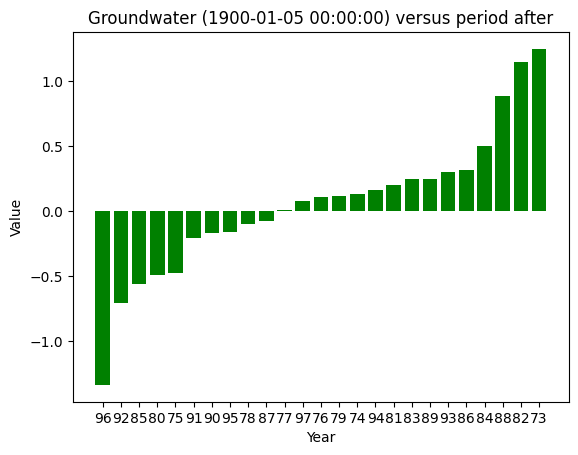

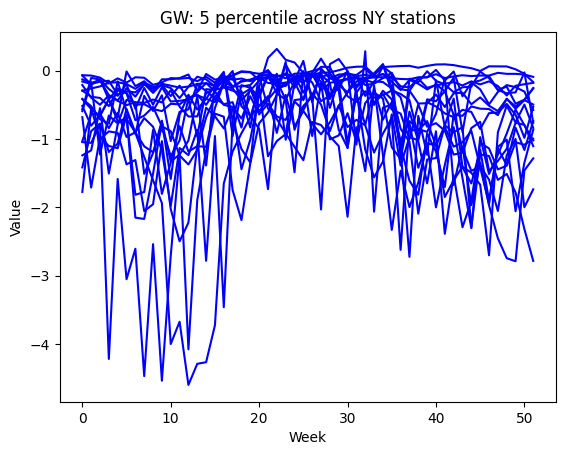

2%
-3.51: 1985/02/12 - 1985/02/25
-2.49: 1977/02/26 - 1977/03/11
-2.40: 1980/03/12 - 1980/03/25
-2.31: 1987/11/19 - 1987/12/02
-2.28: 1994/09/24 - 1994/10/07
-2.22: 1983/12/03 - 1983/12/16
-2.20: 1986/09/24 - 1986/10/07
-2.18: 1979/02/12 - 1979/02/25
-2.03: 1982/02/12 - 1982/02/25
-1.99: 1991/04/09 - 1991/04/22
-1.93: 1992/10/08 - 1992/10/21
-1.91: 1983/11/19 - 1983/12/02


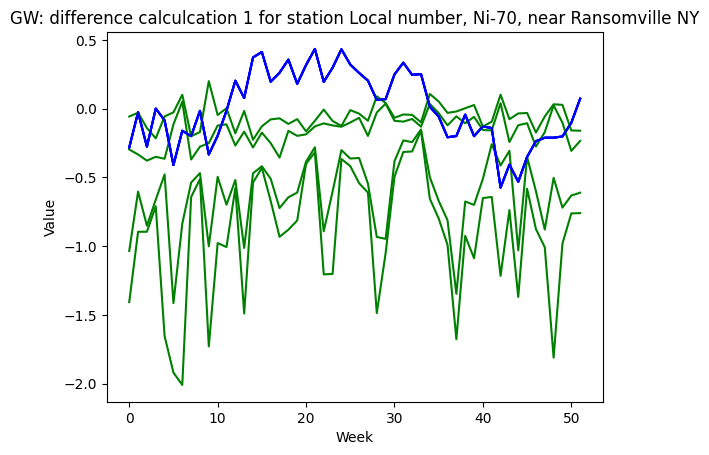

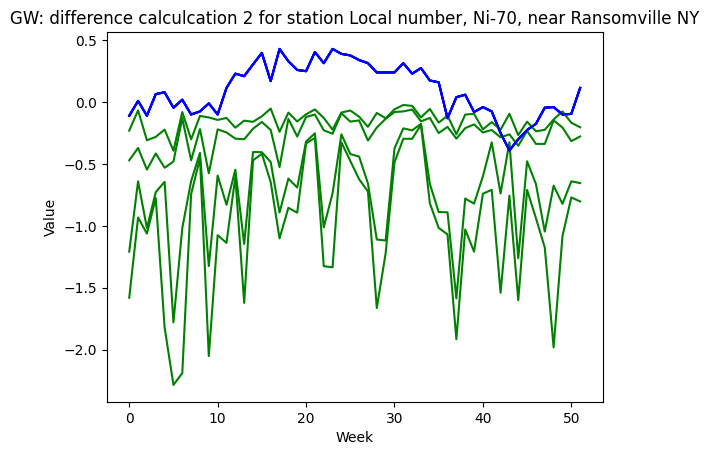

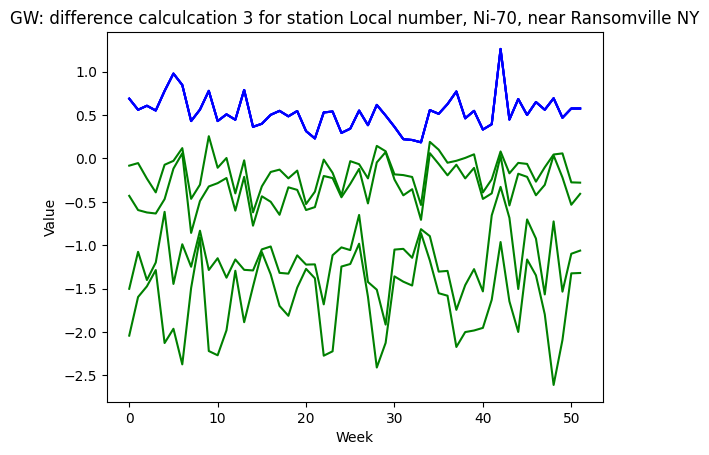

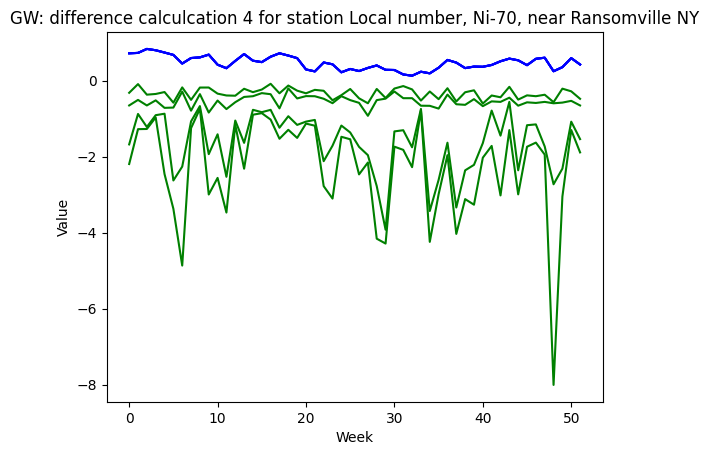

In [8]:
# Control Panel
import statistics as stats
state = "NY"

# Year analysis begins
start_date = "1900"

# Year analysis ends
end_date = "2023"

# Specific date start ("01-05" for Jan 1 - Dec 31)
date = "01-05"

# Distance in weeks looked in each direction of date 
window_in_wks = 0.5

# determines which percentile is graphed, can be list of multiple percentiles
percentile = [5]

data = get_usgs_gw1(state, start_date, end_date)
graph_comparison(data, date, start_date, end_date, 580, window_in_wks, True, percentile)
percent(data, "01-05", start_date, end_date, percentile, state, "all")
#percentile = [5,10,25,33]
#a = percent(data, "01-05", start_date, end_date, percentile, state, "580")
using_all_weeks(data, date, start_date, end_date, 580, 2)
differences(data, "01-14", start_date, end_date, 580, window_in_wks)
#get_station_info(data, state, start_date, end_date)